# Chocolate bar analysis

## Import data

In [1]:
#import dependencies here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

sns.set_style('darkgrid')

#data origin
origin = '..\databases\Chocolate_bar_ratings_2022.csv'
pd.options.display.float_format = '{:,.2f}'.format

## data overview and cleaning


In [2]:
chocolate = pd.read_csv(origin, index_col='REF')

In [3]:
chocolate.head()

,Company (Manufacturer),Company Location,Review Date,Country of Bean Origin,Specific Bean Origin or Bar Name,Cocoa Percent,Ingredients,Most Memorable Characteristics,Rating
REF,,,,,,,,,
2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76%,"3- B,S,C","rich cocoa, fatty, bready",3.25
2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76%,"3- B,S,C","cocoa, blackberry, full body",3.75
2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76%,"3- B,S,C","cocoa, vegetal, savory",3.50
2542,5150,U.S.A.,2021,Fiji,"Matasawalevu, batch 1",68%,"3- B,S,C","chewy, off, rubbery",3.00
2542,5150,U.S.A.,2021,India,"Anamalai, batch 1",68%,"3- B,S,C","milk brownie, macadamia,chewy",3.50


In [4]:
chocolate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2588 entries, 2454 to 2170
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Company (Manufacturer)            2588 non-null   object 
 1   Company Location                  2588 non-null   object 
 2   Review Date                       2588 non-null   int64  
 3   Country of Bean Origin            2588 non-null   object 
 4   Specific Bean Origin or Bar Name  2588 non-null   object 
 5   Cocoa Percent                     2588 non-null   object 
 6   Ingredients                       2501 non-null   object 
 7   Most Memorable Characteristics    2588 non-null   object 
 8   Rating                            2588 non-null   float64
dtypes: float64(1), int64(1), object(7)
memory usage: 202.2+ KB


In [5]:
chocolate['Cocoa Percent'] = (chocolate['Cocoa Percent'].str.replace('%','').astype(float))/100

In [6]:
chocolate.describe()

,Review Date,Cocoa Percent,Rating
count,"2,588.00","2,588.00","2,588.00"
mean,"2,014.55",0.72,3.20
std,4.08,0.06,0.44
min,"2,006.00",0.42,1.00
25%,"2,012.00",0.70,3.00
50%,"2,015.00",0.70,3.25
75%,"2,018.00",0.74,3.50
max,"2,022.00",1.00,4.00


In [7]:
#separate ingredient number from ingredients
chocolate[['Ingredient_number','Ingredients']] = chocolate.Ingredients.str.split('-', expand=True)
chocolate['Ingredient_number'] = chocolate['Ingredient_number'].astype('float').astype('Int64')

In [8]:
regions = pd.read_csv('countries.csv', names=['country','region'])

chocolate = pd.merge(chocolate,regions, how='inner', left_on='Country of Bean Origin',right_on='country')

## Exploratory data analysis

### 1) ¿What attributes makes a chocolate have a better rating?

Before analyzing attributes, lets understand how Rating is distributed across 2588 chocolate bars


In [9]:
chocolate_distribution = chocolate.groupby('Rating')['Rating'].count()/chocolate.Rating.count()

chocolate_distribution.map('{:,.2%}'.format)

Rating
1.00     0.15%
1.50     0.39%
1.75     0.12%
2.00     1.28%
2.25     0.66%
2.50     6.53%
2.75    13.10%
3.00    20.63%
3.25    18.32%
3.50    22.57%
3.75    11.82%
4.00     4.44%
Name: Rating, dtype: object

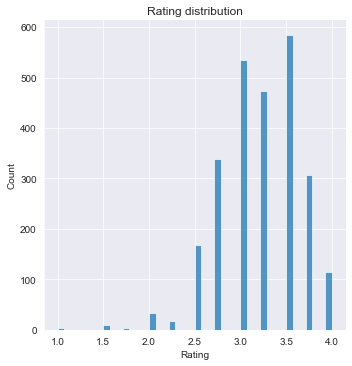

In [10]:
sns.displot(chocolate.Rating).set(title='Rating distribution')

more than 95% of the chocolate bars have a rating greater than or equal to 2.5

Since Rating is a discrete value, lets group them by the categories defined by the responsible of testing and rating the bars

In [11]:
def categorize_rating(x):
    if x <= 2.75:
        return 'dissapointing'
    if x == 3.0 or x == 3.25:
        return 'recommended'
    if x == 3.5 or x == 3.75:
        return 'highly recommended'
    if x == 4.0:
        return 'outstanding'
    
chocolate['Rating_number'] = chocolate['Rating']
chocolate['Rating'] = chocolate['Rating'].apply(categorize_rating)

In [12]:
print('Rating categories frequencies')
chocolate.groupby('Rating')['Rating'].count()/chocolate.Rating.count()

Rating categories frequencies


Rating
dissapointing        0.22
highly recommended   0.34
outstanding          0.04
recommended          0.39
Name: Rating, dtype: float64

#### 1.1) Number of ingredients

Let´s start understanding how ingredient number can affect rating

In [13]:
#Create ingredients_rating dataframe
ingredients_rating = chocolate.loc[:,['Review Date','Ingredient_number','Ingredients', 'Rating']]
ingredients_rating.dropna(axis=0, inplace=True)

#convert ingredients column into list
import ast
ingredients_rating['Ingredients'] = "['"+ingredients_rating.Ingredients.str.replace(' ','').str.replace(",","', '")+"']"
ingredients_rating.Ingredients = ingredients_rating.Ingredients.apply(ast.literal_eval)

[Text(0.5, 1.0, 'Ingredient number % of participation')]

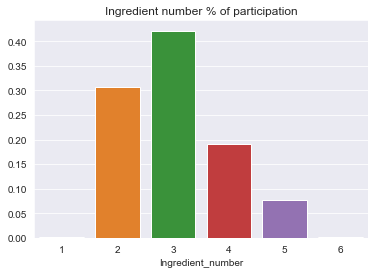

In [14]:
rating_by_number = ingredients_rating.groupby('Ingredient_number')['Ingredient_number'].count()/ingredients_rating.Ingredient_number.count()
sns.barplot(x=rating_by_number.index,y=rating_by_number.values).set(title='Ingredient number % of participation')

In [15]:
rating_by_number = ingredients_rating.groupby(['Ingredient_number','Rating']).count().astype('int')['Review Date']
rating_by_number = pd.DataFrame(rating_by_number).reset_index().rename(columns={"Review Date":"Quantity"})
rating_by_number['Percentage'] = rating_by_number['Quantity'] / rating_by_number.groupby('Ingredient_number')['Quantity'].transform('sum').astype('float')
rating_by_number = rating_by_number[(rating_by_number['Ingredient_number'] >1) & (rating_by_number['Ingredient_number'] <6)]

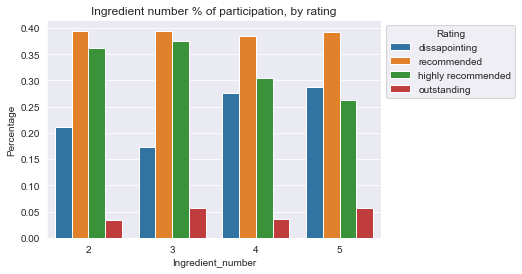

In [16]:
category_order = ['dissapointing', 'recommended','highly recommended', 'outstanding']
ax = sns.barplot(data=rating_by_number, x='Ingredient_number', y='Percentage', hue='Rating', hue_order=category_order)
ax.set(title='Ingredient number % of participation, by rating')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

As number of ingredients increase, most variation occurs in dissapointing and highly recommended frequencies

[Text(0.5, 1.0, 'Decrease in higher rating participation in more ingredients bars')]

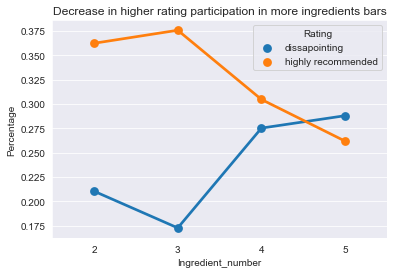

In [17]:
sns.pointplot(data=rating_by_number[(rating_by_number.Rating == 'dissapointing') |  (rating_by_number.Rating == 'highly recommended')],x='Ingredient_number', y='Percentage', hue='Rating').set(title='Decrease in higher rating participation in more ingredients bars')

Number of bars rated as dissapointing increases in bars with more ingredients. Inversely, as number of ingredients increase, number of bars rated as highly recommended decreases

#### 1.2) Ingredients

How ingredients impact bar ratings?

In [18]:
ingredients_rating_exploded = ingredients_rating.explode('Ingredients').reset_index()

ingredient_names = {'B':'Beans', 'S':'Sugar','S*':'Sweetener',  'C':'Cocoa Butter', 'V':'Vanilla', 'L' : 'Lecithin', 'Sa':'Salt'}

ingredients_rating_exploded.Ingredients = ingredients_rating_exploded.Ingredients.replace(ingredient_names)

First let's analyze how are chocolate bars composed

[Text(0.5, 1.0, '% of bars with ingredient')]

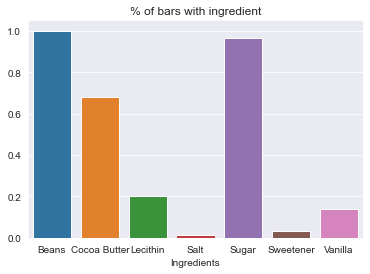

In [19]:
result = ingredients_rating_exploded.groupby('Ingredients').count()['Review Date']/ingredients_rating['Review Date'].count()
sns.barplot(x=result.index, y=result.values).set(title='% of bars with ingredient')

We see that the majority of bars are composed of Cacao Beans, Sugar and Cocoa Butter

Does any ingredient impact on bar rating?

[Text(0.5, 1.0, 'Distribution of ratings per Ingredient')]

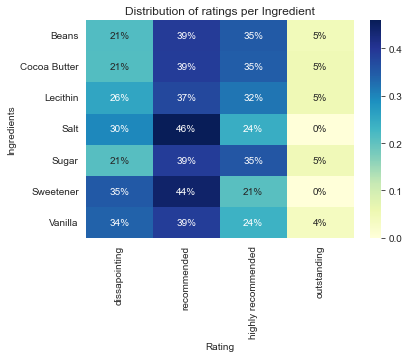

In [20]:
ingredients_contingency = pd.crosstab(index=ingredients_rating_exploded['Ingredients'], columns=ingredients_rating_exploded['Rating'], normalize='index')

ingredients_contingency = ingredients_contingency.reindex(category_order, axis='columns')

sns.heatmap(ingredients_contingency,cmap='YlGnBu', annot=True, fmt='.0%').set(title='Distribution of ratings per Ingredient')

This heatmap shows the distribution of ratings across every ingredient. Bars containing Salt, Sweetener and Vanilla, are more concentrated in lower ratings than the rest of ingredients. 

Is this a sign of relation, or is it due to chance? To determine if it exist a dependence between variables, we have to use a statistical test.

##### Chi-square test of independence:

Chi-square statistic it´s used to determine if it exists a statistical significance in observed frequencies. We'll use it to determine if observed frequencies in ingredients are statistical significant

Since ingredient dataframe is representing many bars at once, we'll have to encode the ingredient variable this way: for every ingredient, a binary column contains YES for every bar that has that ingredient, and NO for every bar that doesn't.

This is beneficial, since it gives us additional information. Now we can compare frequencies between bars that CONTAIN an ingredient and bars that DON'T.

In [21]:
def encode_ingredients(x, column_name):
    for item in x:
        if item == column_name:
            return 'YES'

ingredients_rating_encoded = ingredients_rating
ingredients_rating_encoded['Beans'] = ingredients_rating_encoded['Ingredients'].apply(lambda x: encode_ingredients(x,'B'))
ingredients_rating_encoded['Sugar'] = ingredients_rating_encoded['Ingredients'].apply(lambda x: encode_ingredients(x,'S'))
ingredients_rating_encoded['Sweetener'] = ingredients_rating_encoded['Ingredients'].apply(lambda x: encode_ingredients(x,'S*'))
ingredients_rating_encoded['Cocoa Butter'] = ingredients_rating_encoded['Ingredients'].apply(lambda x: encode_ingredients(x,'C'))
ingredients_rating_encoded['Vanilla'] = ingredients_rating_encoded['Ingredients'].apply(lambda x: encode_ingredients(x,'V'))
ingredients_rating_encoded['Lecithin'] = ingredients_rating_encoded['Ingredients'].apply(lambda x: encode_ingredients(x,'L'))
ingredients_rating_encoded['Salt'] = ingredients_rating_encoded['Ingredients'].apply(lambda x: encode_ingredients(x,'Sa'))

In [22]:
ingredients_rating_encoded.fillna(value='NO',inplace=True)

Hypothesis testing

For every ingredient:

H0: Bars that with the ingredient have simillar ratings that bars without it 

Ha: Bars that with the ingredient have different ratings that bars without it 

Confidence interval: 95%

In [23]:
for column in ingredients_rating_encoded.iloc[:,4:]:
    crosstab = pd.crosstab(index=ingredients_rating_encoded[column], columns=ingredients_rating_encoded['Rating'])
    print(column + ': ' + str(scipy.stats.chi2_contingency(crosstab)[1]))


Beans: 1.0
Sugar: 0.0006687384553445588
Sweetener: 0.0013774321929555275
Cocoa Butter: 0.2119690749034281
Vanilla: 4.620728219723512e-10
Lecithin: 0.04743898998462554
Salt: 0.2063315660390613


Vanilla, Sweetener and Sugar have significant p-values, meaning that the probability of the values we observed are due to chance is really low.

Now that we found an association between some ingredients and their distributions across ratings, let's measure the strength of these associations

##### Cramer's V

Cramer's V measures the association between nominal variables (called the Effect Size). The measure can be interpreted as:

V∈[0.1,0.3]: weak association

V∈[0.4,0.5]: medium association

V>0.5: strong association

In [24]:
def cramers_v(x,dataset):
    dataset = dataset.to_numpy()
    n = np.sum(dataset)
    minimum_dimension = min(dataset.shape)-1

    result = np.sqrt((x/n)/minimum_dimension)
    return result


In [25]:
for column in ingredients_rating_encoded[['Sugar','Sweetener','Vanilla']]:
    crosstab = pd.crosstab(index=ingredients_rating_encoded[column], columns=ingredients_rating_encoded['Rating']).reindex(category_order, axis='columns')
    chi2 = scipy.stats.chi2_contingency(crosstab)[0]
    print(column + " Cramer's V: " + str(cramers_v(chi2,crosstab)))
    plt.show()

Sugar Cramer's V: 0.08272812261083279
Sweetener Cramer's V: 0.07894681970955239
Vanilla Cramer's V: 0.13623498147141164


Vanilla Cramer's V is > 0.1. Based on Effect Size interpretation, we can say that it exists a weak association between Vanilla and Rating

Text(0.5, 1.0, 'Rating distribution, bars with/without vanilla')

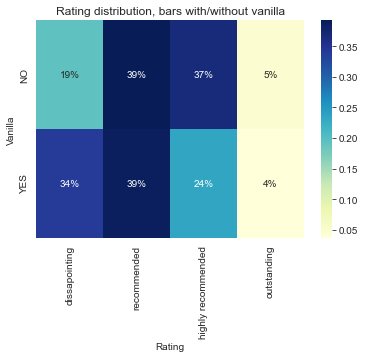

In [26]:
vanilla_crosstab = pd.crosstab(index=ingredients_rating_encoded['Vanilla'], columns=ingredients_rating_encoded['Rating'], normalize='index').reindex(category_order, axis='columns')
sns.heatmap(vanilla_crosstab,cmap='YlGnBu', annot=True, fmt='.0%').set_title('Rating distribution, bars with/without vanilla')

Vanilla presence in the analyzed chocolate bars has a weak association with lower bar Ratings 

#### 1.3) Cocoa Percent

Can cocoa percent affect the overall rating of the bar?

In [27]:
cocoa_rating = chocolate[['Cocoa Percent', 'Rating_number']].reset_index()

Let's start by defining Cocoa Percent data type 

In [28]:
#calculate categorical threshold
if (cocoa_rating['Cocoa Percent'].nunique()/len(cocoa_rating)) < 0.1:
    print("data is discrete")
else:
    print("data is continuous")




data is discrete


The above code tests data cardinality. if unique values/total records count is low (in this case less than 10%) then we can conclude that data is discrete 

In [29]:
cocoa_frequencies = pd.DataFrame(cocoa_rating['Cocoa Percent'].value_counts())
cocoa_frequencies['%'] = cocoa_frequencies['Cocoa Percent'] / np.sum(cocoa_frequencies['Cocoa Percent'])
cocoa_frequencies['cumm %'] = cocoa_frequencies['%'].cumsum()
cocoa_frequencies.head(10)

,Cocoa Percent,%,cumm %
0.70,1070,0.41,0.41
0.75,312,0.12,0.53
0.72,309,0.12,0.65
0.65,93,0.04,0.69
0.80,90,0.03,0.72
0.68,75,0.03,0.75
0.74,69,0.03,0.78
0.73,67,0.03,0.81
0.60,46,0.02,0.82
0.71,44,0.02,0.84


84% of bars can be grouped in these cocoa percents

Most of the chocolate bars having a cocoa percent greater to 60% makes sense since we are analyzing **plain dark chocolate bars**. Context about the topic is always important. That's why I encourage you to read the Flavors of Cacao website, where they document everything about  the dataset

Since both Rating and Cocoa Percent are ordinal values, we can compare both and observed if they are monotonically related.

A monotonic relation means that as the value of one variable increases, the other variable increases too (direct) or decreases (inverse).

This relation can be tested using Spearman's Rank-Order Correlation

In [30]:
scipy.stats.spearmanr(cocoa_rating['Cocoa Percent'], cocoa_rating['Rating_number'])

SpearmanrResult(correlation=-0.10700879647699718, pvalue=4.846891797338299e-08)

Even though p-value is less than 5%, correlation between cocoa percent and Rating is very weak (coef=-0.1 aprox)

### 1.4) Most Memorable Characteristics

Can qualitative attributes affect bar rating? If so, which ones affect the most?

In [31]:
memorable = (chocolate[['Company (Manufacturer)','Country of Bean Origin','region','Most Memorable Characteristics','Rating']]).rename(columns={'Most Memorable Characteristics':'attribute'})



In [32]:
memorable['attribute'] = "['"+memorable.attribute.str.replace(",","', '")+"']"
memorable['attribute'] = memorable.attribute.apply(ast.literal_eval)

memorable_exploded = memorable.explode('attribute')
memorable_exploded['attribute'] = memorable_exploded['attribute'].str.strip()

In [33]:
memorable_exploded['attribute'].nunique()  

991

There are more than 991 memorable characteristics in the dataset, meaning that it is a column with high cardinality. Cardinality refers to the number of possible values a column can have.

the main problem with high cardinality data is [The Curse of Dimensionality](https://towardsdatascience.com/the-curse-of-dimensionality-50dc6e49aa1e). This obstacle arises specially when developing ML models. This can be solved using a correct encoding method.

Since we are only analyzing the data through visualization and inferences, we won't encode this column (encoding can also make visualizations less intuitive and comprehensive).

Instead, we'll reduce cardinality by grouping any characteristic with a frequency lower than the 1% of the total number of records into 'others'.

In [34]:
len(memorable_exploded['attribute'].value_counts()[memorable_exploded['attribute'].value_counts() > 25])

58

With this method, we are able to decrease the number of unique values to 58.

58 unique values still is a big number. Statistical tests (even non-parametric tests like chi-square) lose robustness with high cardinality data. Son we'll have to use another method. 

In [35]:
memorable_list = memorable_exploded['attribute'].value_counts()[memorable_exploded['attribute'].value_counts() > 25].index.to_list()

In [36]:
def categorize_attributes(x, item_list):

    result = 'others'

    for item in item_list:
        if x == item:
            result = item
            break
    
    return result
        

In [37]:
memorable_exploded['attribute_cat'] = memorable_exploded['attribute'].apply(lambda x: categorize_attributes(x,memorable_list))

One method is to rank characteristics by creating a score, based on how many bars with the characteristic fall within a certain rating.

In [38]:
attributes_crosstab = (pd.crosstab(index=memorable_exploded['attribute_cat'], columns=memorable_exploded['Rating'], normalize='index')).reindex(category_order, axis='columns')

attributes_crosstab.sort_values('outstanding', ascending=False).head()

Rating,dissapointing,recommended,highly recommended,outstanding
attribute_cat,,,,
creamy,0.08,0.26,0.46,0.19
complex,0.00,0.25,0.57,0.19
strawberry,0.08,0.35,0.42,0.15
banana,0.13,0.30,0.43,0.15
honey,0.11,0.29,0.46,0.14


Let's give a weight to every rating:

dissapointing: 1

recommended: 2

highly recommended: 3

outstanding: 4

Then, we'll multiply these weights by the frequency of that rating, for that specific characteristic.

Thus, characteristics with higher concentration in better ratings will have a greater ranking and those with higher concentrations in worse ratings will have a lower ranking. 

In [39]:
attributes_crosstab['weight'] = \
attributes_crosstab['dissapointing']*1 + \
attributes_crosstab['recommended']*2 + \
attributes_crosstab['highly recommended']*3 + \
attributes_crosstab['outstanding']*4

Text(0.5, 1.0, 'characteristics ranking distribution')

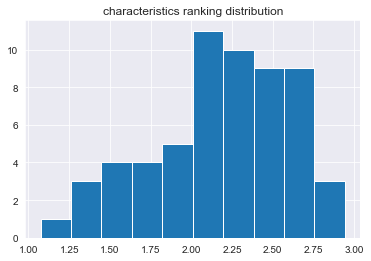

In [40]:
attributes_crosstab['weight'].hist().set_title('characteristics ranking distribution')

In [41]:
print('1st quartile: ' + str(attributes_crosstab['weight'].quantile(.25)))
print('3rd quartile: ' + str(attributes_crosstab['weight'].quantile(.75)))

1st quartile: 1.9324307144673276
3rd quartile: 2.48435972629521


We'll use quartiles as a threshold

Text(0.5, 1.0, 'characteristics with higher ranking than the 75%')

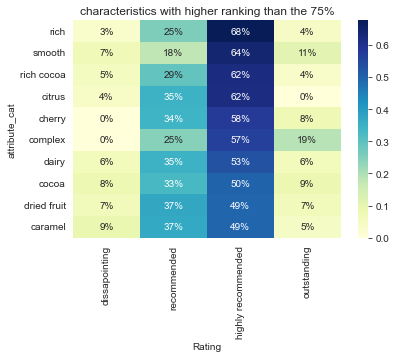

In [42]:
sns.heatmap(attributes_crosstab[attributes_crosstab['weight']>2.49].sort_values(['highly recommended','dissapointing','weight'], ascending=[False,True,False]).head(10).iloc[:,:-1], cmap='YlGnBu', annot=True, fmt='.0%').set_title('characteristics with higher ranking than the 75%')

Notice the amount of characteristics related to flavors fruit (citrus, cherry, dried fruit, caramel, dairy).

Also, cocoa seems to be a memorable characteristic in high rated bars

Text(0.5, 1.0, 'characteristics with higher ranking than the 25%')

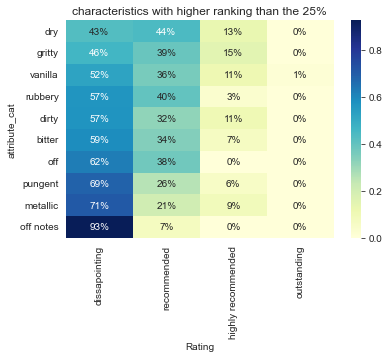

In [43]:
sns.heatmap(attributes_crosstab[attributes_crosstab['weight']<1.98].sort_values(['dissapointing','weight'], ascending=[True, False]).tail(10).iloc[:,:-1], cmap='YlGnBu', annot=True, fmt='.0%').set_title('characteristics with higher ranking than the 25%')


In low rated bars, there are also memorable characteristics referring to flavor (vanilla, rubbery, dirty, pungent, metallic)

If you want to explore every attribute and understand what they represent, check out the [Flavors of Cacao review guide](http://flavorsofcacao.com/review_guide.html)

### 1.5) Country of bean origin 

In [44]:
chocolate['Country of Bean Origin'].nunique()

63

Same as memorable characteristics, there are too many unique values. Anyways, since they are not too many countries, I´ve decided to categorize them manually. 'Region' column was created in cell #9

In [45]:
chocolate['region'].value_counts()

 Central & South America    1705
 Africa                      364
 Asia                        179
 Blend                       156
 North America                89
 Oceania                      35
Name: region, dtype: int64

<AxesSubplot:xlabel='Rating', ylabel='region'>

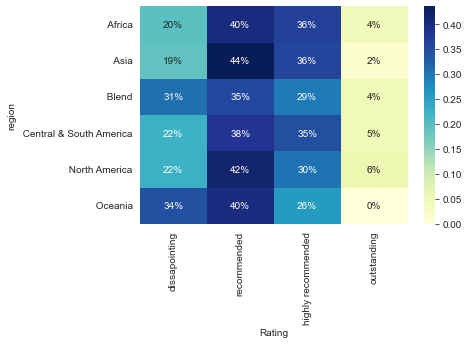

In [46]:
sns.heatmap(pd.crosstab(index=chocolate['region'], columns=chocolate['Rating'],normalize='index').reindex(category_order,axis=1),cmap='YlGnBu', annot=True, fmt='.0%')

Oceania and Blend (this means that Cocoa is a mix of many countries beans) seems to have a higher concentration in low rated bars, compared to the other regions. Let's test it with Chi-Square

##### Chi-square test of independence

H0: There is no association between rating and region of bean origin
Ha: There is association between rating and region of bean origin
Confidence interval: 95%

In [47]:
print('p-value: ' + str(scipy.stats.chi2_contingency(pd.crosstab(index=chocolate['region'], columns=chocolate['Rating']).reindex(category_order,axis=1))[1]))

p-value: 0.1936043603820453


Since p-value is higher than our threshold, we fail to reject the null hypothesis

## Conclusion

1) Lower rating have higher presence in chocolate bars with greater number of ingredients.

2) There is a weak association between chocolate bars with vanilla and lower rating

3) There is no relationship between cocoa percent and rating

4) Many memorable characteristics of high-rated bars are related to fruity flavors and the cocoa used in the bar

5) There is no relationship between cocoa bean region of origin and rating